1. 데이터 전처리하기 
   * 데이터 증강
   * 이미지 정규화
2. CNN으로 이미지 분류하기
   * 모델 정의하기
   * 모델 학습하기
   * 모델 성능 평가하기  
3. 전이 학습 모델 VGG로 분류하기
   * 사전 학습된 모델 불러오기
   * 학습 루프 정의하기
   * 학습 및 성능 평가하기

# 4.2 Data preprocessing

Files already downloaded and verified
Files already downloaded and verified


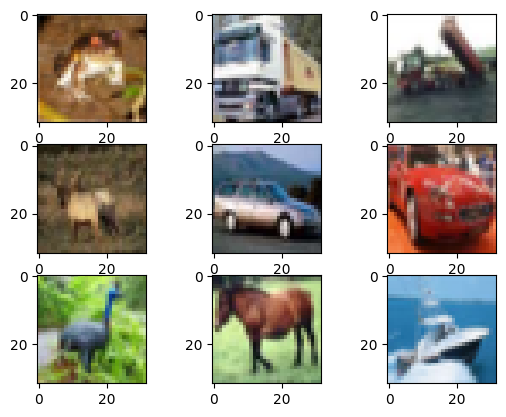

In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

# CIFAR-10 데이터셋 불러오기
training_data = CIFAR10(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor())

test_data = CIFAR10(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data.data[i])
plt.show()

## 4.2.1 데이터 증강
* cropping and Horinzontal Flip

Files already downloaded and verified
Files already downloaded and verified


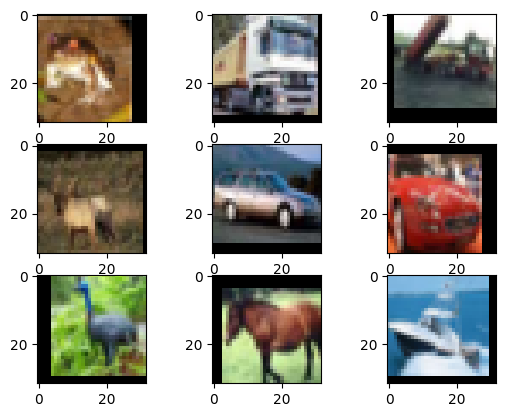

In [2]:
import torchvision.transforms as T

from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([  # 데이터전처리함수 순서대로 넣어주면 적용됨
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4), # 랜덤으로 이미지 일부 제거 후 패딩
    RandomHorizontalFlip(p=0.5),    # y축을 기준으로 대칭
])

training_data = CIFAR10(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor())

test_data = CIFAR10(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()

## 4.2.2 이미지 정규화
### 데이터셋의 평균과 표준편차를 구하고 정규화 진행

In [3]:
import torch 

training_data = CIFAR10(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor())

test_data = CIFAR10(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor())

imgs = [item[0] for item in training_data]

# 이미지를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

# rgb 각 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)

Files already downloaded and verified
Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


Files already downloaded and verified
Files already downloaded and verified


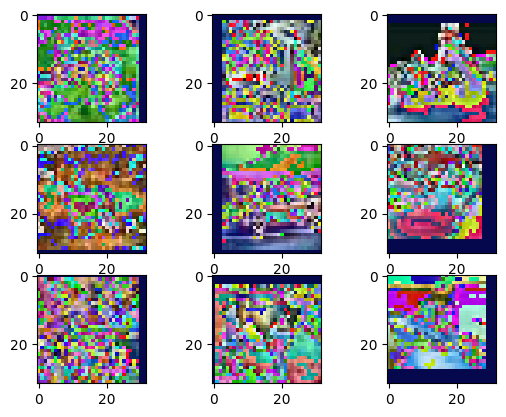

In [4]:
import torchvision.transforms as T

from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([  # 데이터전처리함수 순서대로 넣어주면 적용됨
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4), # 랜덤으로 이미지 일부 제거 후 패딩
    RandomHorizontalFlip(p=0.5),    # y축을 기준으로 대칭
    T.ToTensor(),
    
    Normalize(mean=(mean_r, mean_g, mean_b), std=(std_r, std_g, std_b)),
    T.ToPILImage()
])

training_data = CIFAR10(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor())

test_data = CIFAR10(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.show()

# 4.3 CNN으로 이미지 분류하기
* VGG 모델

In [5]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    # 기본 블럭을 구성하는 층 정의
    def __init__(self, in_channels, out_channels, hidden_dim):
        # nn.Module 클래스의 요소 상속
        super(BasicBlock, self).__init__()
        # convolution layer 정의
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # stride는 커널의 이동 거리
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x): # 기본 블럭의 순전파 정의
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

## 4.3.2 CNN모델 정의하기

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes): # 클래스의 갯수
        super(CNN, self).__init__()
        
        # 합성곱 기본 블럭 정의
        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)
        
        # 분류기 정의
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        
        # 분류기의 활성화 함수
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) # 출력모양: (-1, 256, 4, 4)
        x = torch.flatten(x, start_dim=1) # 2차원의 feature map을 1차원으로
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

## 4.3.3 모델 학습하기

In [7]:
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32, 32), padding=4), # 랜덤 Cropping
    RandomHorizontalFlip(p=0.5), # y축으로 좌우대칭
    ToTensor(), # 텐서로 변환
    Normalize(mean=(mean_r, mean_g, mean_b), std=(std_r, std_g, std_b)) # meand rgb: 0.49139968 0.48215827 0.44653124, std rgb: 0.24703233 0.24348505 0.26158768
])

# 데이터 불러오기
training_data = CIFAR10(root="../data/", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="../data/", train=False, download=True, transform=transforms)

# 데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

## 맥일 경우 아래코드 사용
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

print(f"device 정보: {device}")
# CNN 모델 정의
model = CNN(num_classes=10)

# 모델을 device로 보냄
model.to(device)

Files already downloaded and verified
Files already downloaded and verified
device 정보: cuda


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [8]:

# 학습률 정의
lr = 1e-3

# 최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):
    for data, label in train_loader: # 데이터 호출
        optim.zero_grad() # 기울기를 0으로 초기화
        
        preds = model(data.to(device)) # 모델의 예측
        
        # 오차역전파와 최적화 (손실을 계산하고 backpropagation을 통해 최적화함)
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
    
    if epoch==0 or epoch%10==9: # 10번마다 손실 출력
        print(f"epoch{epoch+1} loss:{loss.item()}")
        
# 모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:1.570468544960022
epoch10 loss:0.5126572847366333
epoch20 loss:0.20781822502613068
epoch30 loss:0.2992795705795288


## 4.3.4 모델 성능 평가하기

In [ ]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.8305


# 4.4 Transfer learning model 이용하기
* ImageNet VGG16
## 4.4.1 사전 학습된 모델 불러오기

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.vgg import vgg16
 
device = "cuda" if torch.cuda.is_available() else "cpu"
 
model = vgg16(pretrained=True) # 모델 객체 생성
fc = nn.Sequential( # 분류층 정의
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(4096,4096),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(4096, 10),
                    )

model.classifier = fc 
model.to(device)

c:\Users\Seojin\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Seojin\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Seojin/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 4.4.2 모델 학습하기

In [ ]:
import tqdm

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
    Resize(224),
    RandomCrop((224, 224), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(mean_r, mean_g, mean_b), std=(std_r, std_g, std_b))
])

In [ ]:
# 데이터 불러오기
training_data = CIFAR10(root="../data/", train=True, download=False, transform=transforms)
test_data = CIFAR10(root="../data/", train=False, download=False, transform=transforms)

# 데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)

for epoch in range(30):
    iterator = tqdm.tqdm(train_loader) # 학습로그 출력
    for data, label in iterator:
        optim.zero_grad()
        preds = model(data.to(device)) # 모델의 예측값 출력
        
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
        
        # tqdm이 출력할 문자열
        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
        
torch.save(model.state_dict(), "CIFAR_pretrained.pth") # 모델저장

epoch:2 loss:0.3389579951763153:  99%|█████████▉| 1551/1563 [2:19:23<01:38,  8.21s/it]  

## 4.4.3 모델 성능 평가하기

In [ ]:
model.load_state_dict(torch.load("CIFAR_pretrained.pth", map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
        
    print(f"Accuracy:{num_coprr/len(test_data)}")

# 4.4 전이학습모델 VGG로 분류
- 4.4.1 사전 학습된 모델 불러오기

In [ ]:
import torch
import torch.nn as nn

from torchsvision.models.vgg import vgg16

device = "cuda" if torch.cuda.is_available() else "cpu"

model = vgg16(pretrained=True) # vgg16 모델 객체 생성
fc = nn.Sequential( # 분류층 정의
                   nn.Linear(512*7*7, 4096),
                   nn.ReLU(),
                   nn.Dropout(),
                   nn.Linear(4096, 4096),
                   nn.ReLU(),
                   nn.Dropout(),
                   nn.Linear(4096, 10),
                   )

model.classifier = fc # VGG의 classifier를 덮어씀
model.to(device)

## 4.4.2 모델 학습하기

``` mean, std값 구하기 코드 복기
import torch 

training_data = CIFAR10(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor())

test_data = CIFAR10(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor())

imgs = [item[0] for item in training_data]

# 이미지를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

# rgb 각 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)
```

In [ ]:
import tqdm

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
    Resize(224),
    RandomCrop((224, 224), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (mean_r, mean_g, mean_b), std = (std_r, std_g, std_b))
])

In [ ]:
training_data = CIFAR10(root="../data/", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="../data/", train=False, download=True, transform=transforms)

# 데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)

for epoch in range(30):
    iterator = tqdm.tqdm(train_loader) # 학습로그 출력
    for data, label in iterator:
        optim.zero_grad()
        
        preds = model(data.to(device)) # 모델의 예측값 출력
        
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
        
        # tqdm이 출력할 문자열
        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
        
torch.save(model.state_dict(), "CIFAR_pretrained.pth") # 모델 저장

## 4.4.3 모델 성능 평가하기

In [ ]:
model.load_state_dict(torch.load("CIFAR_pretrained.pth", map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print(f"Accuracy:{num_corr/len(test_data)}")

